Basically any a neural network is of 3 steps.
- 1:-load the data
- 2:-create the module,train it with the data
- 3:-test the module and predict the output for new set of input

## Packages

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

#### 1 :- load the data

In [30]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    

In [3]:
# Reshape the training and test examples 
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.




#### 2 :-create a module and train it 
- number of layers are 5 i,e 3 hidden layers 
* 1st layer of size (64) (64) (3)i,e 64 pixels image and RGB(3) varient 
- layer 2 of unit 20 , layer 3 of unit 7 and layer 4 of unit 
- The last layer is the output layer

In [4]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

#### 2.1 :- initialize all the parameters needed for each layer 

In [5]:
def initialize_parameters(layer_dims):
    # I/P layer dimension O/P parameter 
    L = len(layer_dims)
    parameters = {}
    np.random.seed(1)
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

#### 2.2 :- calculate the forward propagation 
- calculate Z using W A_prev and b
- using the calculated Z value apply relu until L-1(4) layer to calculate activation function for the Lth layer apply sigmoid function 

In [6]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [7]:
def relu(Z):
     
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [8]:
def linear_forward(A,W,b):
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [9]:
def linear_activation_forward(A_prev,W,b,activation):
    if activation == "sigmoid":
       
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
    
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [10]:
def forward_propagation(X,parameters):
    #I/P X and parameters i,e W and b of all the layers O/P cache that has Z and A of all the layer
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

#### 2.3 :- calculating cost 
using cost = -(Ylog(AL)-(1-Y)log(1-AL))/m

In [11]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-np.dot(Y,np.log(AL).T)-np.dot(1-Y,np.log(1-AL).T))/m
    cost = np.squeeze(cost)
    return cost

#### 2.4 :- Backword Propagation 
to calculate dw db dz of all the layers

In [12]:
def relu_backward(dA,Z):
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [13]:
def sigmoid_backward(dA,Z):
     
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [14]:
def linear_backward(dZ,cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


In [15]:
def linear_activation_backward(dA,caches,activation):
    linear_cache,Z = caches
    
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA,Z)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
    else:
        dZ = relu_backward(dA,Z)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [16]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation ="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

#### 2.5 :- update parameters 
Once we are done with calculating the gradient the next step is to update the parameters

In [17]:
def update_parameters(parameters, grads, learning_rate):
     
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

#### 2.6 :- creating the model by intergrating all the above function

In [19]:
def model_(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []
    #initialize the parameters    
    parameters = initialize_parameters(layers_dims)
    for i in range(0,num_iterations):
        # forward propagate and find the AL value i,e the last layer activation value
        AL,caches = forward_propagation(X,parameters)
        #calculate the cost and store in cost array
        cost = compute_cost(AL, Y)
        #once the cost is calculate the next step is go back and learn the parameters
        #i,e calculate the gradient 
        grads = L_model_backward(AL, Y, caches)
        # now updating the paramters
        parameters = update_parameters(parameters, grads, learning_rate)
        # repeating the step for num_iteration times 
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
        

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


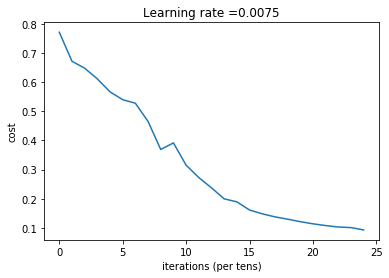

In [20]:
parameters = model_(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

#### 3:- Test the model

In [36]:
m = test_x.shape[1]
n = len(parameters) // 2 # number of layers in the neural network
p = np.zeros((1,m))
# for pridect the output for test_x dataset    
pre, caches = forward_propagation(test_x, parameters)


for i in range(0, pre.shape[1]):
    if probas[0,i] > 0.5:
            p[0,i] = 1
    else:
            p[0,i] = 0
    
print("Accuracy of the model is "  + str(np.sum((p == test_y)/m)*100)+str("%"))
        

Accuracy of the model is 80.0%
